<a href="https://colab.research.google.com/github/stargazingwillow/datascience/blob/main/DATA200-F21_Graduate-Project_Analysis-Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Computer-Associated Item Prices Using Tiered Linear and Random Forest Regression**

***UC Berkeley DATA 200: Principles and Techniques of Data Science***

**Fall 2021 Graduate Final Project (Analysis Notebook)**

Aoi Furukawa (aoifurukawa), Jacob Ellison (jacob_ellison), Michael Yang (michael_yang) {@berkeley.edu}

# 1. Data Sampling & Collection

The dataset is a the sample product metadata for items under the 'Computer' category on Amazon, provided from the following research: "Justifying recommendations using distantly-labeled reviews and fined-grained aspects" (Empirical Methods in Natural Language Processing, 2019).

While this is a comprehensive dataset covering millions of products over several years, we do find some missing values in data cleaning process.

For more information on the original dataset, visit: https://nijianmo.github.io/amazon/.


## 1.1. Importing libraries

In [ ]:
# import libraries
import os
import json
import gzip
from urllib.request import urlopen

import numpy as np
import pandas as pd
import sklearn
import re
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

## 1.2. Importing data

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/sample/meta_Computers.json.gz

--2021-12-16 07:33:37--  http://deepyeti.ucsd.edu/jianmo/amazon/sample/meta_Computers.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7010521 (6.7M) [application/octet-stream]
Saving to: ‘meta_Computers.json.gz.3’

meta_Computers.json 100%[===================>]   6.69M  4.96MB/s    in 1.3s    

2021-12-16 07:33:39 (4.96 MB/s) - ‘meta_Computers.json.gz.3’ saved [7010521/7010521]



In [ ]:
# Load the metadata
data = []
with gzip.open('meta_Computers.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

# Convert list into pandas dataframe
df = pd.DataFrame.from_dict(data)

# 2. Data Cleaning

Each row in the data is a unique product and its metadata, such as its unique ID, title, and description.

The original dataset is in JSON format, which allows nested data, so there may be some columns that need to be further extracted.

## 2.1. Reviewing data

1. **Price Data:** Our dependent variable, `price` had a lot of missing values. This may be because the product is now delisted or the data collection process had issues.  There were 2,650 products with price data in this dataset. While it could be better to have more data, we decided that this would be enough to build a prototype model. Additionally, other datasets required a permission from the author.

2. **Textual Data:** There are several other fields with descriptive words about the product, namely: `title`, `description`, `feature`, `tech1`, `tech`, `details`. However, the vast majority are missing values.

3. **Categorical Variables:** `brand` is a useful categorical variable. `main_cat` is also categorical, but it cannot be used because every data has the same value of 'Computers'.

4. **Metric Variables:** `rank` and `date` could be useful metric variables.

In [ ]:
# Check the shape of dataframe
print('Number of Samples: ' + str(df.shape[0]))
print('Number of Columns: ' + str(df.shape[1]))

Number of Samples: 18772
Number of Columns: 16


In [ ]:
# Check for missing values in the dataset
df.isnull().sum()

description     13642
title               1
image            4688
brand             477
rank              692
main_cat            0
date              184
asin                0
feature         14665
tech1           15186
also_buy        17337
price           16122
also_view       16472
tech2           17113
details         18746
similar_item    18409
dtype: int64

In [ ]:
# Check how many products have price data
df['price'].notnull().sum()

2650

In [ ]:
# Check the dataframe
df.head()

,description,title,image,brand,rank,main_cat,date,asin,feature,tech1,also_buy,price,also_view,tech2,details,similar_item
0,[Brand new. Still in factory-sealed plastic.],Kelby Training DVD: The Adobe Photoshop CS5 7-...,[https://images-na.ssl-images-amazon.com/image...,Kelby Training,"[>#654,681 in Electronics (See Top 100 in Elec...",Computers,"December 2, 2011",0321732960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[If you're already a Photoshop user and want a...,Kelby Training DVD: Adobe Photoshop CS5 Power ...,[https://images-na.ssl-images-amazon.com/image...,Kelby Training,"[>#830,165 in Electronics (See Top 100 in Elec...",Computers,"November 7, 2011",0321735722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[School To Home Notes: Note From the Teacher!\...,TEACHERS FRIEND NOTE FROM THE TEACHER SCHOOL T...,[https://images-na.ssl-images-amazon.com/image...,TEACHERS FRIEND,"[>#1,233,887 in Electronics (See Top 100 in El...",Computers,"June 6, 2007",0439651859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[Dooqi is a young brand specializing in high-e...,"[3-pack]Ipad Mini Screen Protector, Dooqi Scre...",[https://images-na.ssl-images-amazon.com/image...,dooqi,"[>#454,595 in Electronics (See Top 100 in Elec...",Computers,"December 5, 2014",0545729971,"[Hard coated for Scratch Proof (Hardness: 4H),...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[Cover for Nook HD],Hd+ Cheetah Cover- Nook,NaN,Nook,"[>#85,661 in Computers & Accessories (See top ...",Computers,"September 11, 2013",0594450284,[Cheetah cover],"{'Brand Name': 'Nook', 'Item Weight': '1 pound...",NaN,NaN,NaN,NaN,NaN,NaN


## 2.2. Removing data without `price`

Since the price data is required to build a price prediction model, we drop rows without this information to create our dataframe. We also drop 2 rows with a range for its price. The resulting dataframe has 2,648 rows and majority of the other metadata are also included.


In [ ]:
# Remove data without price
df_p = df.dropna( subset=['price'] )
print('Number of samples with price available: ' + str(len(df_p)))

Number of samples with price available: 2650


In [ ]:
# Check if new dataframe has other metadata
df_p.notnull().sum()

description     1708
title           2650
image           1742
brand           2627
rank            2531
main_cat        2650
date            2577
asin            2650
feature         1431
tech1            661
also_buy         534
price           2650
also_view       1090
tech2            230
details           14
similar_item     282
dtype: int64

In [ ]:
# Remove 2 rows with price range given
df_p = df_p[ ~df_p["price"].str.contains(" - ") ]

# Transform price values into float
df_p["price"] = df_p["price"].str.replace("$", "").str.replace(",", "").astype(float)

Median Price: 10.25


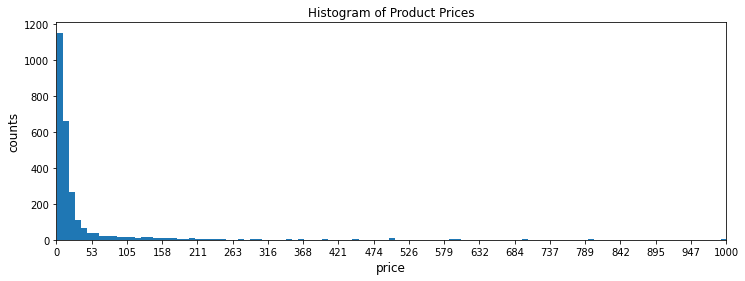

In [ ]:
plt.figure(figsize=(12,4))
plt.hist(df_p["price"],bins=1000);
plt.xlabel('price',size=12)
plt.ylabel('counts',size=12)
plt.xlim(0,1000);
plt.xticks(np.linspace(0,1000,20));
plt.title('Histogram of Product Prices')
#most products are in the range [0,50] and the median price is $10.
print('Median Price: '+str(np.median(df_p["price"])))

## 2.3. Removing data without `rank`

Product ranking is an important metric for its popularity, which is a corollary for how acceptable the price is.

We drop rows without rank information and have 2,531 products (95%).

In [ ]:
# Remove data without rank
df_p = df_p.dropna( subset=['rank'] )
print('Number of Samples with price and rank available: ' + str(len(df_p)))

Number of Samples with price and rank available: 2530


In [ ]:
# Check remaining data for what other features have most filled values
df_p.notnull().sum()/2530

description     0.634387
title           1.000000
image           0.660079
brand           0.990909
rank            1.000000
main_cat        1.000000
date            0.974704
asin            1.000000
feature         0.527668
tech1           0.251383
also_buy        0.199209
price           1.000000
also_view       0.408300
tech2           0.088933
details         0.003557
similar_item    0.110277
dtype: float64

## 2.4. Removing data with extraneous `title`

16 products have `title` values that have extraneous HTML/CSS code in it are removed. 2,514 products remain.

(array([3.880e+02, 1.318e+03, 4.660e+02, 2.840e+02, 2.900e+01, 1.000e+01,
        7.000e+00, 7.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00]),
 array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
        650, 700, 750, 800, 850, 900, 950]),
 <a list of 19 Patch objects>)

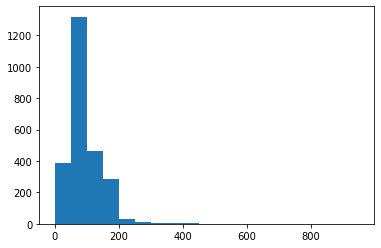

In [ ]:
# Plot distribution of lengths of titles
# There are few outliers with title lengths largers than 300 characters
plt.hist( df_p['title'].str.len(),
         bins = range(0, 1000, 50))

In [ ]:
# Check title for data with title lengths > 300
df_p['title'][ df_p['title'].str.len() > 300 ].head()

1198    var aPageStart = (new Date()).getTime();\nvar ...
1200    var aPageStart = (new Date()).getTime();\nvar ...
1223    var aPageStart = (new Date()).getTime();\nvar ...
1235    var aPageStart = (new Date()).getTime();\nvar ...
1291    var aPageStart = (new Date()).getTime();\nvar ...
Name: title, dtype: object

In [ ]:
# Check the number of data with extraneous values
df_p[ df_p['title'].str.contains('getTime()')].count() # 'getTime' is a shared HTML among these values

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



description     13
title           16
image            8
brand           16
rank            16
main_cat        16
date            16
asin            16
feature         12
tech1            6
also_buy         3
price           16
also_view        2
tech2            1
details          0
similar_item     1
dtype: int64

In [ ]:
df_p = df_p[ ~df_p['title'].str.contains('getTime()') ]
df_p.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



(2514, 16)

## 2.5. Checking resulting dataframe

The resulting dataset after cleaning has 2,514 rows. Every row has `price`, `rank`, and `title`. Most rows (95%+) also have `brand` and `date`. Majority of the rows have `description` (63%) and `feature` (52%).

In [ ]:
# Check shape
df_p.shape

(2514, 16)

In [ ]:
# Check % of filled values in the dataframe
df_p.notnull().sum()/len(df_p)

description     0.633254
title           1.000000
image           0.661098
brand           0.990851
rank            1.000000
main_cat        1.000000
date            0.974543
asin            1.000000
feature         0.526253
tech1           0.250597
also_buy        0.199284
price           1.000000
also_view       0.410103
tech2           0.089101
details         0.003580
similar_item    0.110581
dtype: float64

# 3. Feature Engineering

We featurize the following columns:
* `rank` and `date` as metric variables
* `brand` as categorical variable
* count of keywords in `title` and `description` as a metric variables
* `price` as metric dependent variable

Rationale and methods for featurization can be found for each feature in the subsections below.

## 3.1. Extracting `rank`

Product ranking is an important metric for its popularity, which in turn can be a measure of how 'accepted' the price is.

`rank` is extracted from the string format and converted into a float.

In [ ]:
# Extract the rank from each with regex
df_p['rank'] = df_p['rank'].str[0].str.replace(',', '').str.extract('#([0-9_]+)', expand=False).astype(float)

In [ ]:
df_p['rank']

6        211266.0
10       132547.0
17       942979.0
168      259745.0
171      141338.0
           ...   
18718     11440.0
18738     25740.0
18740    706481.0
18752    367129.0
18769      4064.0
Name: rank, Length: 2514, dtype: float64

## 3.2. Converting `date`

Date of listing signifies how long the product has remained listed. It is possible that the 'age' of product listings are negatively correlated with price because it has become outdated, or it positively correlated because it is a steady seller.

`date` is converted into days by subtracting the date of the earliest product.

In [ ]:
# Convert `date` to days by using days from earliest product
df_p['date_out'] = (pd.to_datetime(df_p['date']) - np.min(pd.to_datetime(df_p['date']))).dt.days

## 3.3. Cleaning miscellaneous `brand`

Brand is an important aspect of a product. Premium brands can be a proxy to qualities such as 'reliability' and command higher prices.

Of 1,117 brands, 73% (793) had only 1 products listed, and 94% (1025) had less than 3 products listed. These brands with only 1 product practically has no brand awareness, so were encoded as `No Brand`.


In [ ]:
# Normalize brand names
df_p['brand'] = df_p["brand"].str.lower().str.replace('[^\w\s]','')

# Calculate number of brands
len(df_p['brand'].unique())

1087

# of brands with only 1 product: 793
% of brands with only 1 product(s): 73.0 %
% of brands with only 2 product(s): 87.0 %
% of brands with only 3 product(s): 91.0 %
% of brands with only 4 product(s): 93.0 %
% of brands with only 5 product(s): 94.0 %
% of brands with only 6 product(s): 95.0 %
% of brands with only 7 product(s): 96.0 %
% of brands with only 8 product(s): 97.0 %
% of brands with only 9 product(s): 97.0 %
% of brands with only 10 product(s): 98.0 %


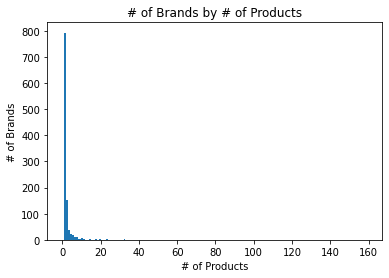

In [ ]:
# Calculate number of products by brands
brand_counts = df_p.groupby('brand').size().sort_values(ascending=False)

# Plot histogram; extremely right-skewed histogram
plt.hist(brand_counts, bins=range(0,160,1))
plt.title("# of Brands by # of Products")
plt.xlabel("# of Products")
plt.ylabel("# of Brands")

# Calculate percentiles for brands with i items
print("# of brands with only 1 product:", (brand_counts == 1).sum())
for i in range(1,11):
  print("% of brands with only", i, "product(s):", round( (brand_counts <= i).sum()/len(brand_counts)*100, 0), "%")

# of brands with more than 10 products: 34


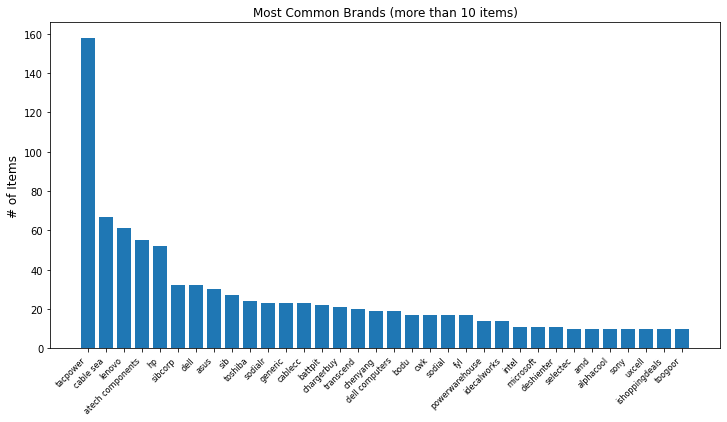

In [ ]:
# Create subset of brands with 10 or more products
brand_counts_gt5 = brand_counts[ brand_counts.values >= 10]
print('# of brands with more than 10 products:', len(brand_counts_gt5))

# Plot # of items by brands
plt.figure(figsize=(12,6))
plt.bar(brand_counts_gt5.index, brand_counts_gt5.values)
plt.xticks(rotation=45, ha='right', size=8);
plt.title('Most Common Brands (more than 10 items)', size=12)
plt.ylabel('# of Items',size=12);

In [ ]:
# Set brand with only 3 item as `no brand`
brand_counts = df_p.groupby('brand', as_index=None).size()
brand_counts['brand_cat'] = brand_counts['brand']
brand_counts['brand_cat'][ brand_counts['size'] <= 10 ] = 'No Brand'
df_p = pd.merge(df_p, brand_counts, how='left', on='brand')
df_p['brand_cat'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



No Brand            1654
tacpower             158
cable sea             67
lenovo                61
atech components      55
hp                    52
dell                  32
sibcorp               32
asus                  30
sib                   27
toshiba               24
cablecc               23
sodialr               23
generic               23
battpit               22
chargerbuy            21
transcend             20
dell computers        19
chenyang              19
fyl                   17
sodial                17
cwk                   17
bodu                  17
powerwarehouse        14
idecalworks           14
intel                 11
microsoft             11
deshienter            11
Name: brand_cat, dtype: int64

## 3.4. Counting keywords in `title` and `description`

Words are the only way for the model to 'understand' what the product actually is. Finding the relationship between word frequency and price is a core part of building this price prediction model.

As seen in Section 2.5., of the filtered dataset, 100% has `title` and 63% has `description`. We parse these by unique word counts to identify potential keywords.

Of more than 26,000 unique words, we identify 16 as our initial set of keywords to featurize.

`feature` (52%), `tech1` (25%), and `tech2` (9%) also have data but have many more missing values. We investigate these features in Section 3.6.

### 3.4.1. Parse data and count unique words

In [ ]:
# Create a count of words by occurence in `title` and `description`
# to review possible candidates for keywords
# and in the process, make parsing in place of original dataframe

# Parsing `title`
title_words = dict()
for title in df_p['title']:
  title = title.split(' ')
  for word in title:
    word = word.lower().strip('.,:!?')
    if word in title_words:
      title_words[word] += 1
    else:
      title_words[word] = 1

# Parsing `description`
desc_words = dict()
df_desc_nona = df_p['description'][ df_p['description'].notnull() ]
for desc in df_desc_nona:
  if len(desc) > 1: # If description is a list of strings,
    desc = ' '.join(desc).strip('.,:!?').split(' ') # convert to single string
  else:
    desc = desc[0].strip('.,:!?').split(' ')
  for word in desc:
    word = word.lower()
    if word in desc_words:
      desc_words[word] += 1
    else:
      desc_words[word] = 1

# Alternative way to parse strings in place
# df_p['description'] = [ [',','.'] if x is np.NaN else x for x in df_p['description'] ]
# df_p['description'] = df_p['description'].apply(lambda x: ','.join(map(str, x)))

In [ ]:
# Join word counts
df_tw = pd.DataFrame.from_dict(title_words, orient='index', columns=['title_words'] )
df_dw = pd.DataFrame.from_dict(desc_words, orient='index', columns=['desc_words'] )
df_w = pd.concat([df_tw, df_dw], axis=1).fillna(0)
df_w['sum_words'] = df_w['title_words'] + df_w['desc_words']
df_w.sort_values(by='sum_words', ascending=False)

,title_words,desc_words,sum_words
the,31.0,4092.0,4123.0
and,158.0,3185.0,3343.0
for,1186.0,1744.0,2930.0
to,220.0,2509.0,2729.0
,15.0,2340.0,2355.0
...,...,...,...
"shuttlepro,",0.0,1.0,1.0
shuttlepro,0.0,1.0,1.0
jobs.,0.0,1.0,1.0
maximizing,0.0,1.0,1.0


### 3.4.2. Featurize lengths of `title` and `description`

In [ ]:
df_p['desc_len']=df_p['description'].str.len()
df_p['title_len']=df_p['title'].str.len()

### 3.4.3. Define functions to extract keywords

In [ ]:
# Define function to count specific keywords in title
def words_in_texts_title(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    texts_ = texts.str.lower()
    arr = []
    for i in words:
        arr.append(list(texts_.str.contains(i)))
        # print(list(texts.str.contains(i)))
    indicator_array = np.array(arr, dtype=float).T
    return indicator_array

In [ ]:
# Define function to count specific keywords in description
def words_in_texts_desc(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    texts_ = texts.str.lower()
    arr = []
    for i in words:
        arr.append(list(texts_.astype(str).str.contains(i)))
        # print(list(texts.str.contains(i)))
    indicator_array = np.array(arr,dtype=float).T
    return indicator_array

### 3.4.4. Featurize counts of keywords

In [ ]:
# Extract keyword counts from `title`
title_keywords = (words_in_texts_title(['laptop','chip','memory','ram','fast', # Computers
                                        'charger','adapter','case','power','card', # Accessories
                                        'headset','controller','mouse','keyboard','touchscreen',
                                        'school','backpack'], # Primary Use
                                        df_p['title']))

# Featurize keyword counts
df_p['laptop_title'] = title_keywords[:,0]
df_p['charger_title'] = title_keywords[:,1]
df_p['memory_title'] = title_keywords[:,2]
df_p['ram_title'] = title_keywords[:,3]
df_p['fast_title'] = title_keywords[:,4]
df_p['case_title'] = title_keywords[:,5]
df_p['chip_title'] = title_keywords[:,6]
df_p['adapter_title'] = title_keywords[:,7]
df_p['school_title'] = title_keywords[:,8]
df_p['power_title'] = title_keywords[:,9]
df_p['backpack_title'] = title_keywords[:,10]
df_p['card_title'] = title_keywords[:,11]
df_p['headset_title'] = title_keywords[:,12]
df_p['controller_title'] = title_keywords[:,13]
df_p['mouse_title'] = title_keywords[:,14]
df_p['keyboard_title'] = title_keywords[:,15]
df_p['touchscreen_title'] = title_keywords[:,16]

In [ ]:
# Extract keyword counts from `description`
desc_keywords = (words_in_texts_desc(['laptop','memory','ram','fast','chip','touch', # Computer
                                   'case','adapter','charger','power', # Accessories
                                   'school','home','business', # Primary Use
                                   'software'], # Software
                                   df_p['description']))
# Featurize keyword counts
df_p['laptop_desc'] = desc_keywords[:,0]
df_p['charger_desc'] = desc_keywords[:,1]
df_p['memory_desc'] = desc_keywords[:,2]
df_p['ram_desc'] = desc_keywords[:,3]
df_p['fast_desc'] = desc_keywords[:,4]
df_p['case_desc'] = desc_keywords[:,5]
df_p['chip_desc'] = desc_keywords[:,6]
df_p['adapter_desc'] = desc_keywords[:,7]
df_p['school_desc'] = desc_keywords[:,8]
df_p['power_desc'] = desc_keywords[:,9]
df_p['home_desc'] = desc_keywords[:,10]
df_p['business_desc'] = desc_keywords[:,11]
df_p['touch_desc'] = desc_keywords[:,12]
df_p['software_desc'] = desc_keywords[:,13]

In [ ]:
df_p.shape

(2514, 52)

## 3.5. Adjusting skewed distribution in `price`

`Price` is our dependent metric variable to predict. In exploring the data, we found a heavily skewed distribution.


Text(0.5, 1.0, 'Histogram of Product Prices')

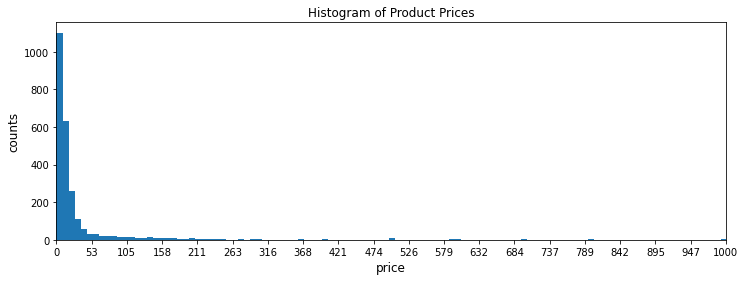

In [ ]:
# Plot histogram of price
plt.figure(figsize=(12,4))
plt.hist(df_p['price'],bins=1000);
plt.xlabel('price',size=12)
plt.ylabel('counts',size=12)
plt.xlim(0,1000);
plt.xticks(np.linspace(0,1000,20));
plt.title('Histogram of Product Prices')

In [ ]:
# Identify median, max, and quartiles
df_p['price'].describe()

# Most products are in the range of [0,50] and the median price is $10.

count    2514.000000
mean       49.378854
std       281.079615
min         0.250000
25%         5.500000
50%        10.000000
75%        22.990000
max      9018.000000
Name: price, dtype: float64

In [ ]:
# Identify 99%ile price
print("99%ile:", df_p['price'].quantile(q=0.99))
print("99.9%ile:", df_p['price'].quantile(q=0.999))

# 99% of the items are under $700
# 99.9% of the itemes are under $3400

99%ile: 698.4799999999996
99.9%ile: 3383.882130000096


In [ ]:
# Remove outliers above $3,000 and create new featurized dataframe `df_p2`
df_p2 = df_p.copy()
df_p2 = df_p[ df_p['price'] <= 3000 ]
df_p2.shape

# 3 items are removed

(2511, 52)

## 3.6 Investigating `tech1` and `tech2`

`tech1` and `tech2` have technical specifications for items. Even though it has a lot of missing values, we explored it to find more potential features.

To test, we extracted weight information and tried a simple linear regression, which had poor accuracy. Because of the missing values, we opted not to featurize these specifications.

In [ ]:
#Create a dataframe with price and tech1
t1_p=df_p[["tech1","price"]].dropna()
t1_p2=t1_p.reset_index()
t1=df_p["tech1"].dropna()
l1=list(t1)
tech1=pd.io.json.json_normalize(t1)
tech1_p=pd.concat([t1_p2["price"],tech1], axis=1)
tech1_p.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



,price,Brand Name,Item Weight,Package Dimensions,Item model number,Product Dimensions,Item Dimensions L x W x H,Processor Count,California residents,Color,Batteries,Hardware Platform,Screen Size,Operating System,RAM,Graphics Card Ram Size,Processor,National Stock Number,Computer Memory Type,Series,Power Source,Wireless Type,Part Number,Item Package Quantity,Certification,Batteries Included?,Batteries Required?,Memory Speed,Number of USB 2.0 Ports,Material,Included Components,Voltage,Max Screen Resolution,Hard Drive,Graphics Coprocessor,Chipset Brand,Number of USB 3.0 Ports,Average Battery Life (in hours),Size,Manufacturer Part Number,Card Description,Number of Items,Screen Resolution,Usage,Warranty Description,Material Type,Processor Brand,Brand,Model,Rear Webcam Resolution,Flash Memory Size
0,6.99,PQI USA,9.6 ounces,8.5 x 5.2 x 1.2 inches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.00,APC,10.36 pounds,NaN,AR8359,21.2 x 23 x 3.5 inches,21.25 x 23 x 3.5 inches,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13.49,Metro Vacuum,10.6 ounces,NaN,CCF-1,3.5 x 6.7 x 7.5 inches,3.54 x 6.69 x 7.48 inches,NaN,Click here for Proposition 65 warning,Blue,2 D batteries required.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
tech1_p.shape

(630, 51)

In [ ]:
tech1.isnull().sum()

Brand Name                         304
Item Weight                        273
Package Dimensions                 528
Item model number                  321
Product Dimensions                 388
Item Dimensions  L x W x H         407
Processor Count                    620
California residents               619
Color                              490
Batteries                          615
Hardware Platform                  595
Screen Size                        457
Operating System                   616
RAM                                490
Graphics Card Ram Size             625
Processor                          501
National Stock Number              627
Computer Memory Type               625
Series                             594
Power Source                       626
Wireless Type                      517
Part Number                        624
Item Package Quantity              623
Certification                      628
Batteries Included?                623
Batteries Required?      

Since there are too many null values, we decided to see weight values if there is correlation with price.
The values includes pounds and ounces, therefore we extracted numbers and transform them into float.

In [ ]:
# Extract numbers of pounds from tech1 data and transform it into float.
reg="([.*0-9]+) pounds"
w1=tech1_p["Item Weight"].str.extract(reg).astype(float)
# times by 16 to convert the values into ounces
w1[0]=w1[0]*16
w1=w1.dropna()

# Extract numbers of ounces from tech1 data and transform it into float.
ounces="([.*0-9]+) ounces"
w2=tech1_p["Item Weight"].str.extract(ounces).astype(float)
w2=w2.dropna()
w2=w2.rename(columns={0:1})

# Merge two dataframes and create new column that has ounce values.
w3=pd.concat([w1,w2], axis=1)
w3=w3.fillna(0)
w3["weight"]=w3[0]+w3[1]

# Create a new dataframe with the tech1 data and ounce weight
newdf=pd.merge(tech1_p, w3, left_index=True, right_index=True)
# Extract only price and weight
newdf=newdf[["price","weight"]]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



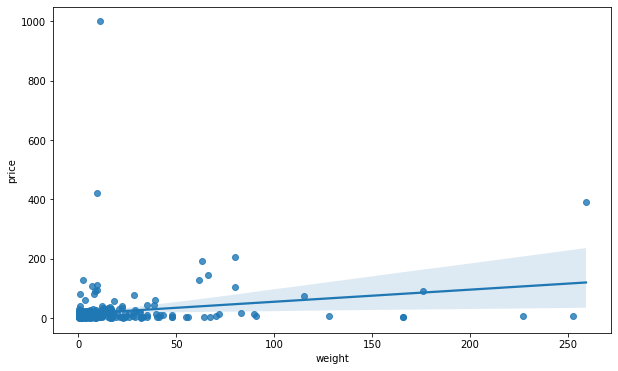

In [ ]:
# Visualize the relationship between two values.
plt.figure(figsize=(10,6))
sns.regplot(newdf["weight"], newdf["price"])

There are some outliers. To make the model better, we removed outliers.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



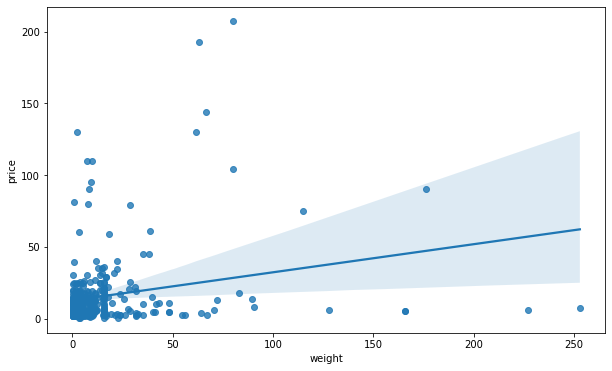

In [ ]:
# Look at only data with price less than 220
newdf_1=newdf[newdf["price"]<220]
plt.figure(figsize=(10,6))
sns.regplot( newdf_1["weight"], newdf_1["price"])

In [ ]:
# We created prediction model only with these two values and see coefficient and score
model=LinearRegression()
model.fit(newdf_1[["weight"]], newdf_1["price"])
model.coef_, model.score(newdf_1[["weight"]], newdf_1["price"])

(array([0.19593847]), 0.05353503585275787)

To improve the model, we checked values of tech2 as well. If tech2 can complement tech1, we could use more data.

In [ ]:
# Create dataframe only includes tech1 and tech2
df_tech=df_p[["tech1","tech2"]]

# Remove rows if both are null
df_tech=df_tech[df_tech.isna().all(axis=1)==False]
df_tech.isnull().sum()

tech1      0
tech2    406
dtype: int64


As you can see from the result, there is no row that only has tech2 value. Threfore, we found that data of tech2 cannot complement missing data of tech1.

## 3.7. Extracting subcategory from `rank`

While extracting `rank` variable, we noticed that many strings had ranks in `electronics` category, instead of our original `computer` category.

We find a promising clustering among products ranked in `electronics` category, and thus convert this into a categorical variable.


There are some categories in "rank" column.

In [ ]:
df["rank"]

0        [>#654,681 in Electronics (See Top 100 in Elec...
1        [>#830,165 in Electronics (See Top 100 in Elec...
2        [>#1,233,887 in Electronics (See Top 100 in El...
3        [>#454,595 in Electronics (See Top 100 in Elec...
4        [>#85,661 in Computers & Accessories (See top ...
                               ...                        
18767    [>#372,769 in Electronics (See Top 100 in Elec...
18768    [>#308,759 in Electronics (See Top 100 in Elec...
18769    [>#4,064 in Computers & Accessories (See top 1...
18770    [>#449,492 in Electronics (See Top 100 in Elec...
18771    [>#278,362 in Electronics (See Top 100 in Elec...
Name: rank, Length: 18772, dtype: object

In [ ]:
# Count categories by extracting name of the category
category=df['rank'].str[0].str.replace(',', '').str.extract('in ([A-Za-z &*]+) ', expand=False)
category.value_counts()

Electronics                14374
Computers & Accessories     3658
Office Products                4
Beauty & Personal Care         1
Home & Kitchen                 1
Automotive                     1
Video Games                    1
Name: rank, dtype: int64

Most of categories are either Electronics or Computers & Accessories.
So we examine values of these two categories.

In [ ]:
# Extract the rank from each with regex
tmp=df

# Extract ranks only from Electronics
el=tmp['rank'].str[0].str.replace(',', '').str.extract('#([0-9_]+) in Electronics', expand=False).astype(float)
tmp["El_rank"]=el

tmp=tmp[["price", "rank","El_rank"]]
tmp.head(2)

,price,rank,El_rank
0,NaN,"[>#654,681 in Electronics (See Top 100 in Elec...",654681.0
1,NaN,"[>#830,165 in Electronics (See Top 100 in Elec...",830165.0


In [ ]:
# Remove categories other than Electronics and Computers & Accessories
tmp = tmp[ ~tmp["rank"].str.contains("Office Products|Beauty & Personal Care|Home & Kitchen|Automotive|Video Games", na=False) ]

# Remove 2 rows with price range given
tmp = tmp[ ~tmp["price"].str.contains(" - ", na=False) ]

#tmp = tmp[ ~tmp["price"].str.contains(" - ") ]
# Transform price values into float
tmp["price"] = tmp["price"].str.replace("$", "").str.replace(",", "").astype(float)

In [ ]:
# Extract rank numbers
tmp["rank"]=tmp['rank'].str[0].str.replace(',', '').str.extract('#([0-9_]+)', expand=False).astype(float)

# Add new column that includes 1 if the category is Electronics and 0 if not.
tmp3=tmp[tmp["El_rank"]>0]
tmp3["El_rank"]=1
tmp["El"]=tmp3["El_rank"]
tmp=tmp.dropna(subset=["price"])
tmp=tmp.fillna(0)
tmp=tmp.drop(columns="El_rank")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



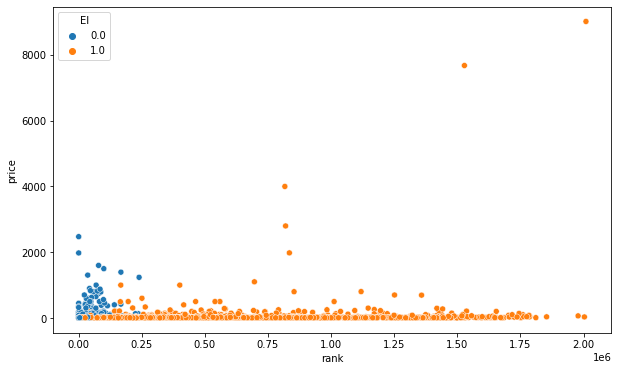

In [ ]:
# Plot price and rank values to see the relationship.
plt.figure(figsize=(10,6))
sns.scatterplot(tmp["rank"], tmp["price"], hue=tmp["El"])

In [ ]:
tmp.groupby("El").mean()

,price,rank
El,,
0.0,74.000651,42205.401752
1.0,40.495423,514594.362405


The products in Electronics category(El=1), have wider range of rank and lower mean price.

# 4. Exploratory Data Analysis

## 4.1. Checking relationship between `price` and `brand`

As part of our EDA, we conduct simple linear regression on price and brand. We do not find a significant relationship.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



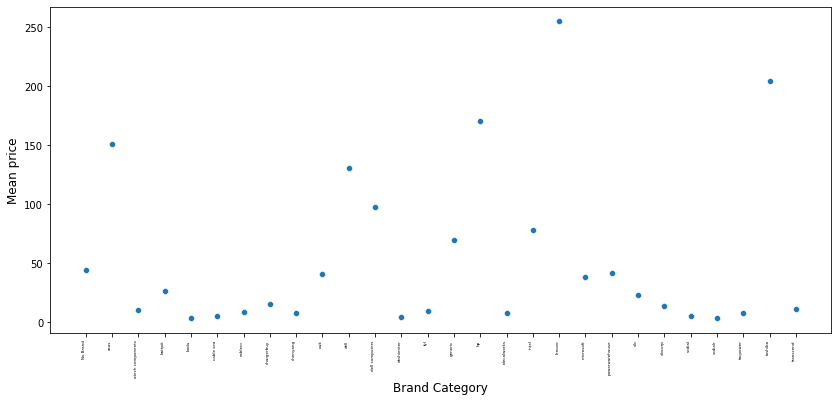

In [ ]:
q41=df_p.dropna(subset=["brand_cat"])
#df_p.isnull().sum()
#sns.regplot(q41["brand_cat"], q41["price"])
q41_2=q41[["brand_cat", "price"]].groupby(["brand_cat"]).mean()

#q41_2
plt.figure(figsize=(14,6))
sns.scatterplot(q41_2.index, q41_2["price"])
plt.xlabel('Brand Category',size=12);
plt.ylabel('Mean price',size=12);
plt.xticks(rotation=90, ha='right', size=4);

In [ ]:
brand=pd.DataFrame(q41["brand_cat"].value_counts())
brand
q41_2=q41[["brand_cat", "price"]].groupby(["brand_cat"]).mean()
q41_2
brand["price"]=q41_2["price"]
brand.head()

,brand_cat,price
No Brand,1654,44.528640
tacpower,158,7.827089
cable sea,67,5.390000
lenovo,61,255.087213
atech components,55,10.173273


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



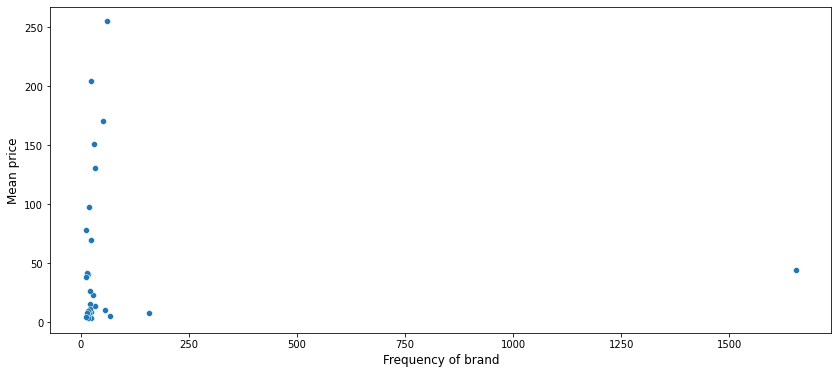

In [ ]:
# Frequency of brand and price
plt.figure(figsize=(14,6))
sns.scatterplot(brand["brand_cat"], brand["price"])
plt.xlabel('Frequency of brand',size=12);
plt.ylabel('Mean price',size=12);
#plt.xticks(rotation=90, ha='right', size=12);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



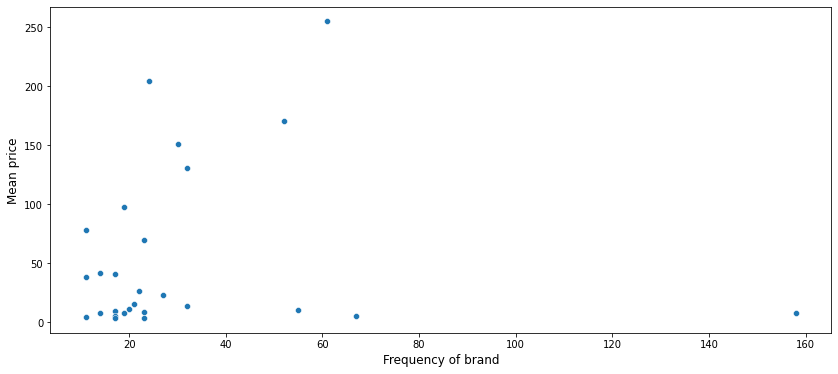

In [ ]:
# Remove No brand
plt.figure(figsize=(14,6))
sns.scatterplot(brand[brand["brand_cat"]<700]["brand_cat"], brand[brand["brand_cat"]<700]["price"])
plt.xlabel('Frequency of brand',size=12);
plt.ylabel('Mean price',size=12);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



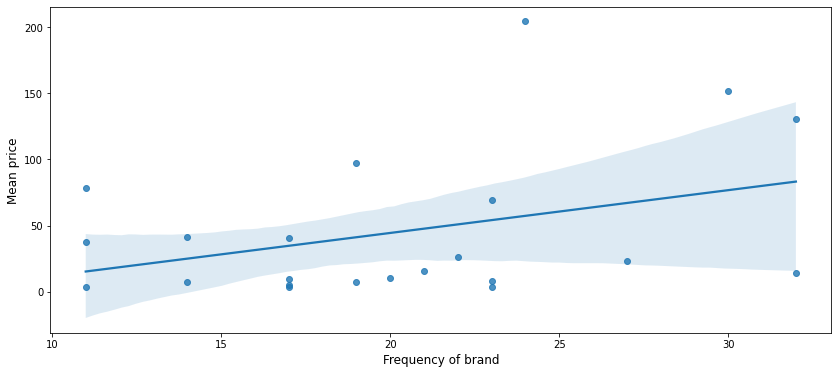

In [ ]:
plt.figure(figsize=(14,6))
#sns.scatterplot(brand[brand["brand_cat"]<40]["brand_cat"], brand[brand["brand_cat"]<40]["price"])
sns.regplot(brand[brand["brand_cat"]<40]["brand_cat"], brand[brand["brand_cat"]<40]["price"])
plt.xlabel('Frequency of brand',size=12);
plt.ylabel('Mean price',size=12);

According to the plot above, the frequency of brand doesn't affect price of the product.

## 4.2. Checking relationship between `price` and `rank`

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



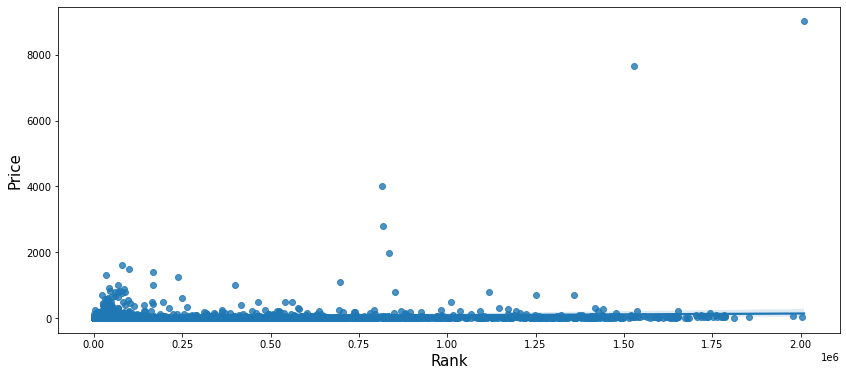

In [ ]:
plt.figure(figsize=(14,6))
#sns.scatterplot(df_p["rank"], df_p["price"])
sns.regplot(df_p["rank"], df_p["price"])

plt.xlabel('Rank',size=15);
plt.ylabel('Price',size=15);
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



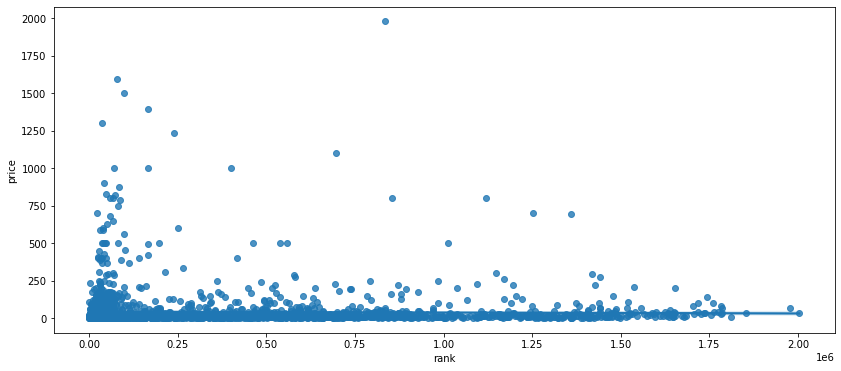

In [ ]:
# Remove outliers
# See products with price less than 2000
#df_p[df_p["price"]<2000]
plt.figure(figsize=(14,6))
sns.regplot(df_p[df_p["price"]<2000]["rank"], df_p[df_p["price"]<2000]["price"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



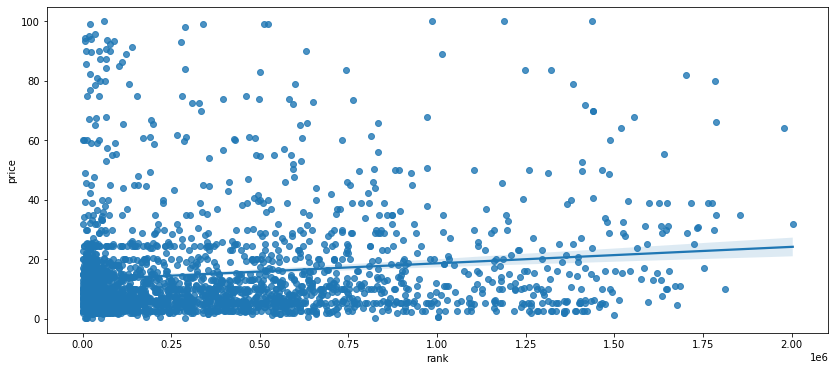

In [ ]:
plt.figure(figsize=(14,6))
sns.regplot(df_p[df_p["price"]<100]["rank"], df_p[df_p["price"]<100]["price"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



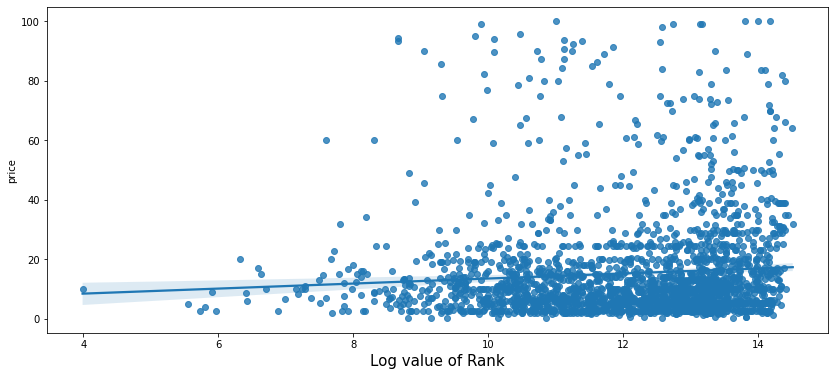

In [ ]:
#log of rank
plt.figure(figsize=(14,6))
sns.regplot(np.log(df_p[df_p["price"]<100]["rank"]), df_p[df_p["price"]<100]["price"])
plt.xlabel('Log value of Rank',size=15);

In [ ]:
tmp=df_p[df_p["price"]<100]
tmp=tmp.dropna(subset=["rank"])

In [ ]:
# check coef

#tmp=df_p[df_p["price"]<100][["rank"]]
model=LinearRegression()
model.fit(np.log(tmp[["rank"]]),tmp["price"])
model.coef_, model.intercept_

(array([0.84659281]), 5.055377959835019)

## 4.1. Creating dataframe with dummies for categorical variables

In [ ]:
# Create X dataset, with dummies for categorical variables `brand_cat`
X = pd.get_dummies(df_p2[['laptop_title','charger_title','memory_title','ram_title','fast_title','case_title',\
                                 'chip_title','adapter_title','school_title','backpack_title' ,'card_title','headset_title','controller_title',\
                                 'mouse_title','keyboard_title','touchscreen_title',\
                                 'brand_cat','rank','price',\
                                 'laptop_desc','charger_desc','memory_desc','ram_desc','fast_desc','case_desc',\
                                 'chip_desc','adapter_desc','school_desc','power_desc','home_desc','business_desc','touch_desc','software_desc', 'date_out',\
                                 'desc_len','title_len'
                                  ]])
X.dropna()

# Check shape of dataframes before and after
print("Filtered Dataset Shape `df_p2`:", df_p2.shape)
print("No-NA Dataset Shape `X_train`:", X.shape)

Filtered Dataset Shape `df_p2`: (2511, 52)
No-NA Dataset Shape `X_train`: (2511, 63)


In [ ]:
# Normalize `rank`, `date_out`, `desc_len`, `title_len`
X['rank'] = X['rank'] / np.max(X['rank'])
X['date_out'] = X['date_out'] / np.max(X['date_out'])
X['desc_len'] = X['desc_len'] / np.max(X['desc_len'])
X['title_len'] = X['title_len'] / np.max(X['title_len'])

In [ ]:
# Add intercept
X['intcpt'] = np.ones((len(X),1))

In [ ]:
# Check final shape
print('Shape of X: ' + str(X.shape))

Shape of X: (2511, 64)


## 4.2. Checking relationships between `title_keywords` and `desc_keywords`

In [ ]:
import numpy as np
def words_in_texts_title(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    texts_ = texts.str.lower()
    arr =[]
    for i in words:
        arr.append(list(texts_.str.contains(i)))
        # print(list(texts.str.contains(i)))
    indicator_array = np.array(arr,dtype=float).T
    return indicator_array

In [ ]:
df_h=df_p
#Extract Date by using days from earliest product
df_h['date_out']=(pd.to_datetime(df_h['date']) - np.min(pd.to_datetime(df_h['date']))).dt.days

In [ ]:
df_h['description'] = [ [',','.'] if x is np.NaN else x for x in df_h['description'] ]
df_h['description'] = df_h['description'].apply(lambda x: ','.join(map(str, x)))
df_h['desc_len']=df_h['description'].str.len()
df_h['title_len']=df_h['title'].str.len()
df_h['description'] = df_h['description'].str.lower()
df_h['title'] = df_h['title'].str.lower()

In [ ]:
def words_in_texts_desc(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    
    texts_ = texts.str.lower()
    arr =[]
    for i in words:
        arr.append(list(texts_.str.contains(i)))
        # print(list(texts.str.contains(i)))
    indicator_array = np.array(arr,dtype=float).T
    return indicator_array

In [ ]:
sets_words = (words_in_texts_title(['laptop','charger','memory','ram','fast','case',\
                                    'chip','adapter','school','power', 'backpack', 'card',\
                                    'headset','controller','mouse','keyboard','touchscreen'],df_h['title']))
trainy=df_h.copy()
trainy['laptop_title']=sets_words[:,0]
trainy['charger_title']=sets_words[:,1]
trainy['memory_title']=sets_words[:,2]
trainy['ram_title']=sets_words[:,3]
trainy['fast_title']=sets_words[:,4]
trainy['case_title']=sets_words[:,5]
trainy['chip_title']=sets_words[:,6]
trainy['adapter_title']=sets_words[:,7]
trainy['school_title']=sets_words[:,8]
trainy['power_title']=sets_words[:,9]
trainy['backpack_title']=sets_words[:,10]
trainy['card_title']=sets_words[:,11]
trainy['headset_title']=sets_words[:,12]
trainy['controller_title']=sets_words[:,13]
trainy['mouse_title']=sets_words[:,14]
trainy['keyboard_title']=sets_words[:,15]
trainy['touchscreen_title']=sets_words[:,16]

In [ ]:
sets_words = (words_in_texts_desc(['laptop','charger','memory','ram','fast','case',\
                                   'chip','adapter','school','power','home','business','touch','software'],df_h['description']))
trainy['laptop_desc']=sets_words[:,0]
trainy['charger_desc']=sets_words[:,1]
trainy['memory_desc']=sets_words[:,2]
trainy['ram_desc']=sets_words[:,3]
trainy['fast_desc']=sets_words[:,4]
trainy['case_desc']=sets_words[:,5]
trainy['chip_desc']=sets_words[:,6]
trainy['adapter_desc']=sets_words[:,7]
trainy['school_desc']=sets_words[:,8]
trainy['power_desc']=sets_words[:,9]
trainy['home_desc']=sets_words[:,10]
trainy['business_desc']=sets_words[:,11]
trainy['touch_desc']=sets_words[:,12]
trainy['software_desc']=sets_words[:,13]

In [ ]:
X_train = pd.get_dummies(trainy[['laptop_title','charger_title','memory_title','ram_title','fast_title','case_title',\
                                 'chip_title','adapter_title','school_title','backpack_title' ,'card_title','headset_title','controller_title',\
                                 'mouse_title','keyboard_title','touchscreen_title',\
                                 'brand_cat','rank','price',\
                                 'laptop_desc','charger_desc','memory_desc','ram_desc','fast_desc','case_desc',\
                                 'chip_desc','adapter_desc','school_desc','power_desc','home_desc','business_desc','touch_desc','software_desc', 'date_out',\
                                 'desc_len','title_len'
                                  ]])
# X_train = trainy[['laptop','charger','memory','ram','fast','case','chip','adaptor','school','rank','price']]
# Y_train = trainy['price']

In [ ]:
# Normalize values
X_train['rank'] = X_train['rank'] / np.max(X_train['rank'])
X_train['date_out'] = X_train['date_out'] / np.max(X_train['date_out'])
X_train['desc_len'] = X_train['desc_len'] / np.max(X_train['desc_len'])
X_train['title_len'] = X_train['title_len'] / np.max(X_train['title_len'])


In [ ]:
# Remove price outliers
X_train = X_train.dropna()
X_tot = X_train.copy()
X_train = X_train[X_train['price']<=3000]

In [ ]:
X_corr = X_tot.drop(['price'], axis=1)
X_ac = X_tot['price']

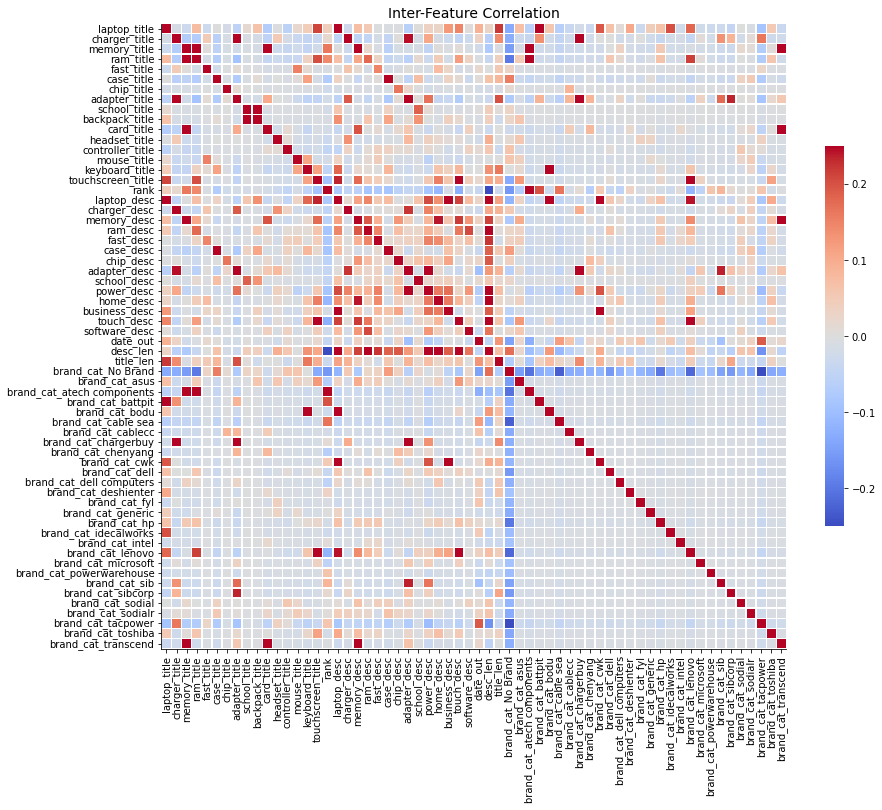

In [ ]:
# Check redundancy by visualizing inter-feature correlation
corr = X_corr.corr()
g = sns.heatmap(corr, vmax=.25, vmin=-.25, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=False, cmap='coolwarm',xticklabels=True, yticklabels=True)
sns.despine()
g.figure.set_size_inches(14,14)
plt.title('Inter-Feature Correlation',size=14)
plt.show()

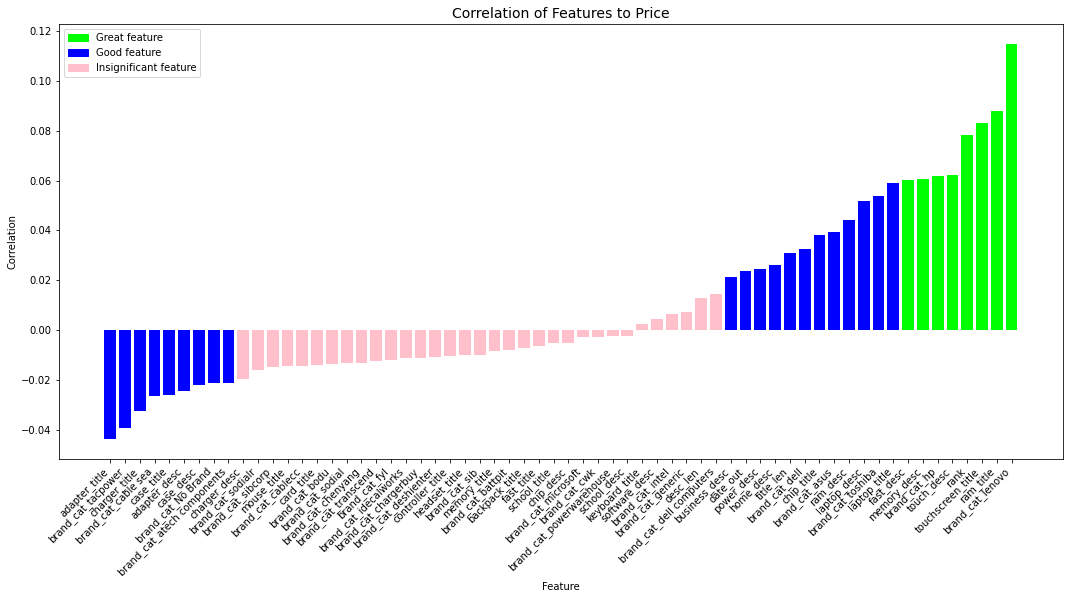

In [ ]:
# Evaluate the significance of each feature
# by checking its correlation to price
corrs=[]
colorc=[]
for i in range(np.shape(X_corr)[1]):
  cc=X_corr.iloc[:,i].corr(X_ac)
  corrs.append(cc)
  if abs(cc) >.06:
    colorc.append('lime')
  elif (abs(cc) <=.06) and abs(cc) >.02:
    colorc.append('blue')
  else:
    colorc.append('pink')

pdata = pd.DataFrame()
pdata['Corrs'] = corrs
pdata['Colors'] = colorc
pdata['labels'] = X_corr.keys()

pdata = pdata.sort_values('Corrs',axis=0)

plt.figure(figsize=(18,8))
plt.bar(pdata['labels'],(np.array(pdata['Corrs'])),color=pdata['Colors'])
plt.xticks(rotation=45, ha='right', size=10);
plt.title('Correlation of Features to Price',size=14)
plt.ylabel('Correlation')
plt.xlabel('Feature');
colors = {'Great feature':'lime', 'Good feature':'blue','Insignificant feature':'pink'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

# 4. Initial Modeling: Subsetted Multiple Linear Regression


## 4.1. Set up datasets

In [ ]:
# X_set = X.dropna()
# Y_set = X_set['price']
# X_tota = X_set.copy()
# X_set = X_set.drop(labels='price', axis=1)

# print("X shape:", str(X_set.shape))
# print("Y shape:", str(Y_set.shape))

# X_train, X_test, y_train, y_test = train_test_split(X_set, Y_set, test_size=0.2, random_state=42)
# model1 = LinearRegression()
# model1.fit(X_train, y_train)

In [ ]:
Y_train = X_train['price']

X_train = X_train.drop(labels='price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## 4.2. Fit linear regression model

In [ ]:
# plt.plot((preds),(y_train),'.')
# plt.figure(figsize=(18,8))

# plt.subplot(121)
# preds=model1.predict(X_train)
# preds[preds<0]=0
# plt.title('Model on Training Data - ' + \
#           ' R^2: ' + str(np.round(model1.score(X_train, y_train),3)) +\
#           ' MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_train),3)),size=14)
# sns.regplot(x=preds[::1],y=y_train[::1],marker='.');
# plt.xlabel('predicted price')
# plt.ylabel('true price')

# plt.subplot(122)
# preds=model1.predict(X_test)
# preds[preds<0]=0 # Normalize negative predictions to 0
# plt.title('Model on Testing Data - ' + \
#           ' R^2: ' + str(np.round(model1.score(X_test, y_test),3)) +\
#           ' MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_test),3)),size=14)
# sns.regplot(x=(preds[::1]),y=(y_test[::1]),marker='.')
# plt.xlabel('predicted price')
# plt.ylabel('true price');


In [ ]:
# # plt.plot((preds),(y_train),'.')
# plt.figure(figsize=(18,8))
# plt.subplot(121)
# preds=model.predict(X_train)
# preds[preds<0]=0
# plt.title('Model on Training Data, R Squared='+ str(np.round(model.score(X_train, y_train),3))+ ', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_train),3)),size=14)
# sns.regplot(x=preds[::1],y=y_train[::1],marker='.');
# plt.xlabel('predicted price')
# plt.ylabel('true price')
# plt.subplot(122)
# preds=model.predict(X_test)
# preds[preds<0]=0
# plt.title('Model on Testing Data, R Squared='+ str(np.round(model.score(X_test, y_test),3))+ ', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_test),3)),size=14)
# sns.regplot(x=(preds[::1]),y=(y_test[::1]),marker='.')
# plt.xlabel('predicted price')
# plt.ylabel('true price');

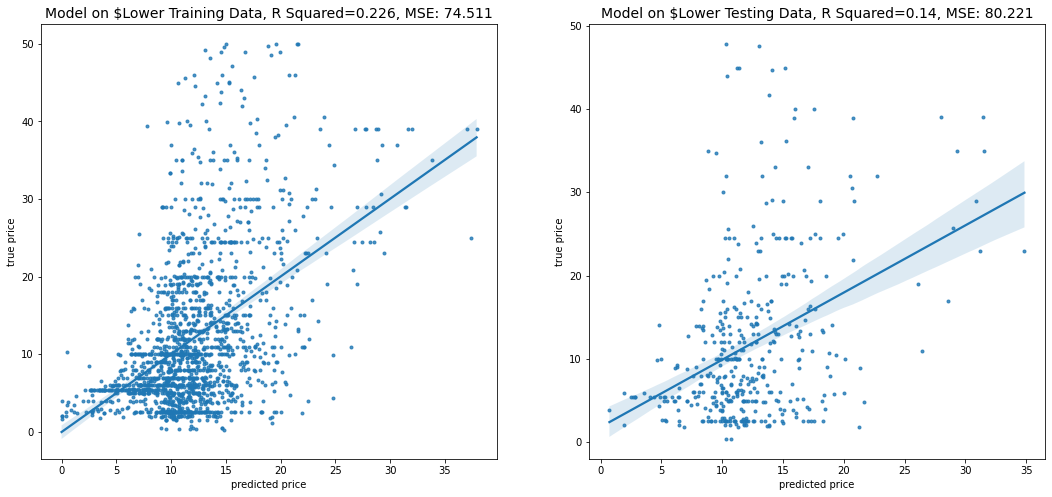

In [ ]:
# now lets split the samples into groups of [0,50], and [50,inf] and create two different models
X_lower = X_tot[X_tot['price']<50]
X_upper = X_tot[X_tot['price']>=50]
X_lower = X_tot[X_tot['price']<50]
Y_lower = X_lower['price']
X_lower = X_lower.drop(labels='price', axis=1)
X_tlow, X_testlow, y_tlow, y_testlow = train_test_split(X_lower, Y_lower, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_tlow, y_tlow)
# plt.plot((preds),(y_train),'.')
plt.figure(figsize=(18,8))
plt.subplot(121)
preds=model.predict(X_tlow)
preds[preds<0]=0
plt.title('Model on $Lower Training Data, R Squared='+ str(np.round(model.score(X_tlow, y_tlow),3))+ ', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_tlow),3)),size=14)
sns.regplot(x=preds[::1],y=y_tlow[::1],marker='.');
plt.xlabel('predicted price')
plt.ylabel('true price')
plt.subplot(122)
preds=model.predict(X_testlow)
preds[preds<0]=0
plt.title('Model on $Lower Testing Data, R Squared='+ str(np.round(model.score(X_testlow, y_testlow),3))+', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_testlow),3)),size=14)
sns.regplot(x=(preds[::1]),y=(y_testlow[::1]),marker='.')
plt.xlabel('predicted price')
plt.ylabel('true price');

## 4.3. Subsetting dataset by price 

In [ ]:
# X_lo_train.shape, 

In [ ]:
# # now lets split the samples into groups of [0,50], and [50,inf] and create two different models
# X_lo = X[ X['price']<50 ].dropna()
# Y_lo = X_lo['price']
# X_lo = X_lo.drop(labels='price', axis=1)
# X_lo_train, X_lo_test, y_lo_train, y_lo_test = train_test_split(X_lo, Y_lo, test_size=0.2, random_state=42)

# # Train linear regression model on cheaper products
# model1a = LinearRegression()
# model1a.fit(X_lo_train, y_lo_train)

# # Plot linear regression on cheaper products
# # Plot for training set
# plt.figure(figsize=(18,8))
# plt.subplot(121)
# preds=model1a.predict(X_lo_train)
# preds[preds<0]=0
# plt.title('Model on $Lower Training Data, R Squared='+ str(np.round(model1a.score(X_lo_train, y_lo_train),3))+ ', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_lo_train),3)),size=14)
# sns.regplot(x=preds[::1],y=y_lo_train[::1],marker='.');
# plt.xlabel('predicted price')
# plt.ylabel('true price')
# # Plot for testing set
# plt.subplot(122)
# preds=model1a.predict(X_lo_test)
# preds[preds<0]=0
# plt.title('Model on $Lower Testing Data, R Squared='+ str(np.round(model1a.score(X_lo_test, y_lo_test),3))+', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_lo_test),3)),size=14)
# sns.regplot(x=(preds[::1]),y=(y_lo_test[::1]),marker='.')
# plt.xlabel('predicted price')
# plt.ylabel('true price');

In [ ]:
# Y_upper = X_upper['price']
# X_upper = X_upper.drop(labels='price', axis=1)
# X_tup, X_testup, y_tup, y_testup = train_test_split(X_upper, Y_upper, test_size=0.2, random_state=42)
# model = LinearRegression()
# model.fit(X_tup, y_tup)
# # plt.plot((preds),(y_train),'.')
# plt.figure(figsize=(18,8))
# plt.subplot(121)
# preds=model.predict(X_tup)
# preds[preds<0]=0
# plt.title('Model on $Upper Training Data, R Squared='+ str(np.round(model.score(X_tup, y_tup),3))+ ', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_tup),3)),size=14)
# sns.regplot(x=preds[::1],y=y_tup[::1],marker='.');
# plt.xlabel('predicted price')
# plt.ylabel('true price')
# plt.subplot(122)
# preds=model.predict(X_testup)
# preds[preds<0]=0
# plt.title('Model on $Upper Testing Data, R Squared='+ str(np.round(model.score(X_testup, y_testup),3))+', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_testup),3)),size=14)
# sns.regplot(x=(preds[::1]),y=(y_testup[::1]),marker='.')
# plt.xlabel('predicted price')
# plt.ylabel('true price');

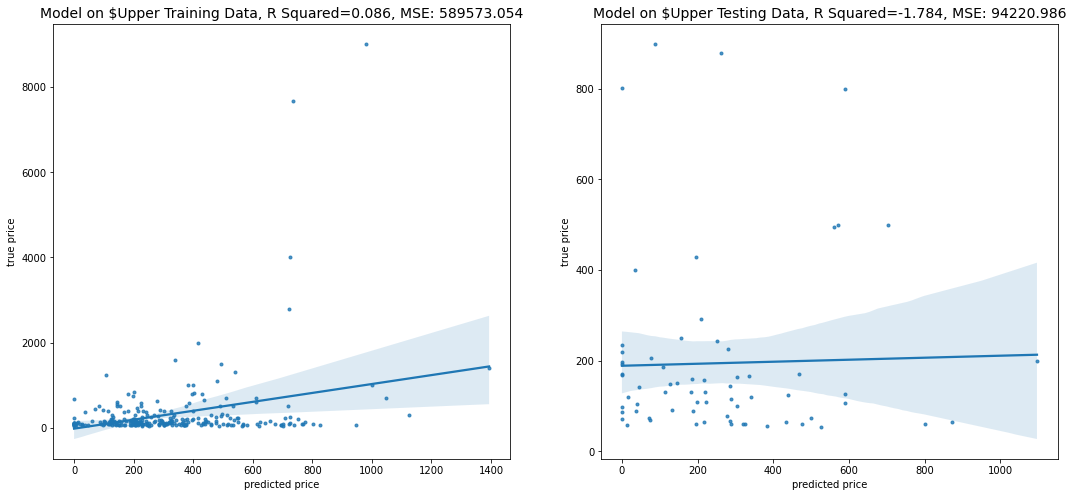

In [ ]:
X_upper = X_tot[X_tot['price']>=50]

Y_upper = X_upper['price']
X_upper = X_upper.drop(labels='price', axis=1)
X_tup, X_testup, y_tup, y_testup = train_test_split(X_upper, Y_upper, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_tup, y_tup)
# plt.plot((preds),(y_train),'.')
plt.figure(figsize=(18,8))
plt.subplot(121)
preds=model.predict(X_tup)
preds[preds<0]=0
plt.title('Model on $Upper Training Data, R Squared='+ str(np.round(model.score(X_tup, y_tup),3))+ ', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_tup),3)),size=14)
sns.regplot(x=preds[::1],y=y_tup[::1],marker='.');
plt.xlabel('predicted price')
plt.ylabel('true price')
plt.subplot(122)
preds=model.predict(X_testup)
preds[preds<0]=0
plt.title('Model on $Upper Testing Data, R Squared='+ str(np.round(model.score(X_testup, y_testup),3))+', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_testup),3)),size=14)
sns.regplot(x=(preds[::1]),y=(y_testup[::1]),marker='.')
plt.xlabel('predicted price')
plt.ylabel('true price');


# 5. Subsetting Optimization: PCA with Decision Trees

## 5.1. Conducting PCA

In [ ]:
#now run PCA to see if there are clusters and see if there are better splitting criteria
u,s,vt = np.linalg.svd(X_train)

In [ ]:
PCs=X_train@vt[:3,:].T

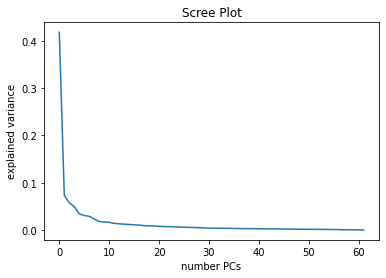

In [ ]:
plt.title('Scree Plot')
plt.ylabel('explained variance')
plt.xlabel('number PCs')
plt.plot(s**2/np.sum(s**2));

In [ ]:
print('Maximally Contributing features to the top three PCs:')
X_train.keys()[np.argmax(vt[:,0])],X_train.keys()[np.argmax(vt[:,1])],X_train.keys()[np.argmax(vt[:,2])],

Maximally Contributing features to the top three PCs:


('fast_title', 'controller_title', 'adapter_title')

In [ ]:
px.scatter_3d(x=PCs[0], y=PCs[1], z= PCs[2])
#it seems like there are two seperable clusters

## 5.2. Analyzing most significant features with decision trees

In [ ]:
# find single feature that maximizes entropy of the system 
max_ent_feature=[]
max_ent = 0
for i in range(X_train.shape[1]):
  Group = X_train.iloc[:,i] >= .5
  Pg1 = len(X_train[Group])/len(X_train)
  Pg2 = len(X_train[~Group])/len(X_train)
  if Pg1 == 0: H1 = 0
  else: H1 = -1 *Pg1*np.log2(Pg1)

  if Pg2 == 0: H2 = 0
  else: H2 = -1 *Pg1*np.log2(Pg1)

  if H1 + H2 > max_ent:
    max_ent_feature = i
    max_ent = H1 + H2
print('Maximum Entropy = ' + str(max_ent))
print("Single Feature Maximizing Entropy: " + X_train.keys()[max_ent_feature])


Maximum Entropy = 0.7987325679726613
Single Feature Maximizing Entropy: brand_cat_No Brand


In [ ]:
px.scatter_3d(x=PCs[0],y=PCs[1],z= PCs[2], color=X_train['brand_cat_No Brand'].replace({0:'Common Brand',1:'Uncommon Brand'}))
#clusters represent products with no category and products with category

In [ ]:
model = LinearRegression()
p=30
model.fit(X_train@vt[:p,:].T, y_train)
model.score(X_test@vt[:p,:].T, y_test)
#model accuracy trained on just 30 PCs is about the same

0.01183394693739448

## 5.3. Grouping by brands to improve models

In [ ]:
# # now lets split the samples into groups of Brand and No brand and create and additional two different models
# X_lower = X_tot[X_tot['price']<50]
# Y_lower = X_lower['price']
# X_lower = X_lower.drop(labels='price', axis=1)
# # X_tlow, X_testlow, y_tlow, y_testlow = train_test_split(X_lower, Y_lower, test_size=0.2, random_state=42)
# X_tot = X_set.copy()
# X_lower = X_tot[X_tot['brand_cat_No Brand']==1]
# X_upper = X_tot[X_tot['brand_cat_No Brand']==0]
# # Y_lower = X_lower['price']
# # X_lower = X_lower.drop(labels='price', axis=1)
# X_tlow, X_testlow, y_tlow, y_testlow = train_test_split(X_lower, Y_lower, test_size=0.2, random_state=42)
# model = LinearRegression()
# model.fit(X_tlow, y_tlow)
# # plt.plot((preds),(y_train),'.')
# plt.figure(figsize=(18,8))
# plt.subplot(121)
# preds=model.predict(X_tlow)
# preds[preds<0]=0
# plt.title('Model on Uncommon Brand \n Training Data, R Squared='+ str(np.round(model.score(X_tlow, y_tlow),3))+ ', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_tlow),3)),size=14)
# sns.regplot(x=preds[::1],y=y_tlow[::1],marker='.');
# plt.xlabel('predicted price')
# plt.ylabel('true price')
# plt.subplot(122)
# preds=model.predict(X_testlow)
# preds[preds<0]=0

# plt.title('Model on Uncommon Brand \n Testing Data, R Squared='+ str(np.round(model.score(X_testlow, y_testlow),3))+', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_testlow),3)),size=14)
# sns.regplot(x=(preds[::1]),y=(y_testlow[::1]),marker='.')
# plt.xlabel('predicted price')
# plt.ylabel('true price');

In [ ]:
# # now lets split the samples into groups of Brand and No brand and create and additional two different models
# X_lower = X_tot[X_tot['brand_category_No Brand']==1]
# X_upper = X_tot[X_tot['brand_category_No Brand']==0]
# Y_lower = X_lower['price']
# X_lower = X_lower.drop(labels='price', axis=1)
# X_tlow, X_testlow, y_tlow, y_testlow = train_test_split(X_lower, Y_lower, test_size=0.2, random_state=42)
# model = LinearRegression()
# model.fit(X_tlow, y_tlow)
# # plt.plot((preds),(y_train),'.')
# plt.figure(figsize=(18,8))
# plt.subplot(121)
# preds=model.predict(X_tlow)
# preds[preds<0]=0
# plt.title('Model on Uncommon Brand \n Training Data, R Squared='+ str(np.round(model.score(X_tlow, y_tlow),3))+ ', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_tlow),3)),size=14)
# sns.regplot(x=preds[::1],y=y_tlow[::1],marker='.');
# plt.xlabel('predicted price')
# plt.ylabel('true price')
# plt.subplot(122)
# preds=model.predict(X_testlow)
# preds[preds<0]=0

# plt.title('Model on Uncommon Brand \n Testing Data, R Squared='+ str(np.round(model.score(X_testlow, y_testlow),3))+', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_testlow),3)),size=14)
# sns.regplot(x=(preds[::1]),y=(y_testlow[::1]),marker='.')
# plt.xlabel('predicted price')
# plt.ylabel('true price');

In [ ]:
# Y_upper = X_upper['price']
# X_upper = X_upper.drop(labels='price', axis=1)
# X_tup, X_testup, y_tup, y_testup = train_test_split(X_upper, Y_upper, test_size=0.2, random_state=42)
# model = LinearRegression()
# model.fit(X_tup, y_tup)
# # plt.plot((preds),(y_train),'.')
# plt.figure(figsize=(18,8))
# plt.subplot(121)
# preds=model.predict(X_tup)
# preds[preds<0]=0

# plt.title('Model on Common Brand \n Training Data, R Squared='+ str(np.round(model.score(X_tup, y_tup),3))+ ', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_tup),3)),size=14)
# sns.regplot(x=preds[::1],y=y_tup[::1],marker='.');
# plt.xlabel('predicted price')
# plt.ylabel('true price')
# plt.subplot(122)
# preds=model.predict(X_testup)
# preds[preds<0]=0

# plt.title('Model on Common Brand \n Testing Data, R Squared='+ str(np.round(model.score(X_testup, y_testup),3))+', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_testup),3)),size=14)
# sns.regplot(x=(preds[::1]),y=(y_testup[::1]),marker='.')
# plt.xlabel('predicted price')
# plt.ylabel('true price');


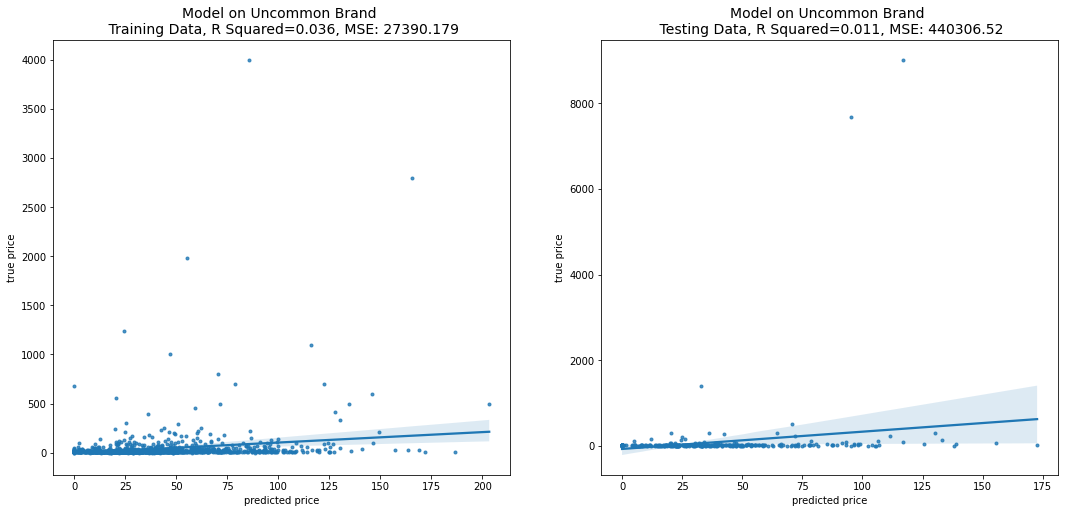

In [ ]:
# now lets split the samples into groups of Brand and No brand and create and additional two different models
X_lower = X_tot[X_tot['brand_cat_No Brand']==1]
X_upper = X_tot[X_tot['brand_cat_No Brand']==0]
Y_lower = X_lower['price']
X_lower = X_lower.drop(labels='price', axis=1)
X_tlow, X_testlow, y_tlow, y_testlow = train_test_split(X_lower, Y_lower, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_tlow, y_tlow)
# plt.plot((preds),(y_train),'.')
plt.figure(figsize=(18,8))
plt.subplot(121)
preds=model.predict(X_tlow)
preds[preds<0]=0
plt.title('Model on Uncommon Brand \n Training Data, R Squared='+ str(np.round(model.score(X_tlow, y_tlow),3))+ ', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_tlow),3)),size=14)
sns.regplot(x=preds[::1],y=y_tlow[::1],marker='.');
plt.xlabel('predicted price')
plt.ylabel('true price')
plt.subplot(122)
preds=model.predict(X_testlow)
preds[preds<0]=0

plt.title('Model on Uncommon Brand \n Testing Data, R Squared='+ str(np.round(model.score(X_testlow, y_testlow),3))+', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_testlow),3)),size=14)
sns.regplot(x=(preds[::1]),y=(y_testlow[::1]),marker='.')
plt.xlabel('predicted price')
plt.ylabel('true price');

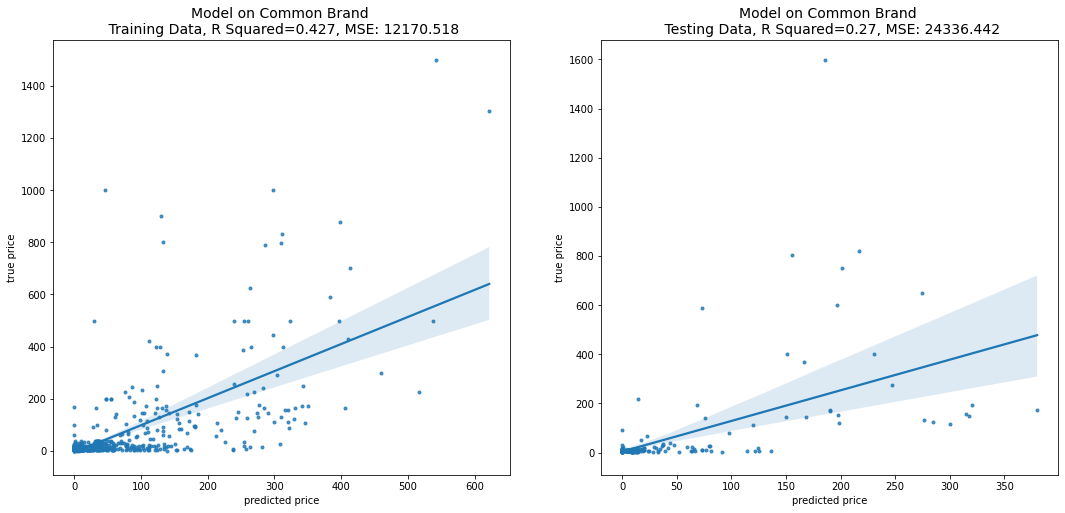

In [ ]:
Y_upper = X_upper['price']
X_upper = X_upper.drop(labels='price', axis=1)
X_tup, X_testup, y_tup, y_testup = train_test_split(X_upper, Y_upper, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_tup, y_tup)
# plt.plot((preds),(y_train),'.')
plt.figure(figsize=(18,8))
plt.subplot(121)
preds=model.predict(X_tup)
preds[preds<0]=0

plt.title('Model on Common Brand \n Training Data, R Squared='+ str(np.round(model.score(X_tup, y_tup),3))+ ', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_tup),3)),size=14)
sns.regplot(x=preds[::1],y=y_tup[::1],marker='.');
plt.xlabel('predicted price')
plt.ylabel('true price')
plt.subplot(122)
preds=model.predict(X_testup)
preds[preds<0]=0

plt.title('Model on Common Brand \n Testing Data, R Squared='+ str(np.round(model.score(X_testup, y_testup),3))+', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_testup),3)),size=14)
sns.regplot(x=(preds[::1]),y=(y_testup[::1]),marker='.')
plt.xlabel('predicted price')
plt.ylabel('true price');


As you can see from the result, there is no row that only has tech2 value. Threfore, we found that data of tech2 couldn't complement missing data of tech1.

# 6. Improved Model: Random Forest Regression and Hyper-Parameter Optimization

## 6.1. Hyper-Parameter Optimization with 3-fold CV Grid Search

In [ ]:
# now lets split the samples into groups of Brand and No brand and with our price cutoff
X_upper = X_tot[X_tot['brand_cat_No Brand']==0]
X_upper = X_upper[X_upper['price']<=50]
Y_upper = X_upper['price']
X_upper = X_upper.drop(labels='price', axis=1)
X_tup, X_testup, y_tup, y_testup = train_test_split(X_upper, Y_upper, test_size=0.2, random_state=42)

In [ ]:
# Conduct hyperparameter optimization
# 3-fold CV with grid search for hyper-parameters:
# max depth and number of estimators
from sklearn.ensemble import RandomForestRegressor
best_score=0
best_params = []
for i in [10,20,30,40,50,100]:
  for j in [30,50,100,200]:
    model = RandomForestRegressor(n_estimators=j, criterion='squared_error', max_depth=i, max_features='auto')
    score = np.mean(sklearn.model_selection.cross_val_score(model,X_tup,y_tup,cv=3))
    if score > best_score:
      best_params = [j,i]
      best_score = score

# Optimal hypermarameter was 200 in max depth and 100 estimators
best_score

0.4354596463947111

In [ ]:
best_params

[200, 40]

## 6.2. Random Forest Regression

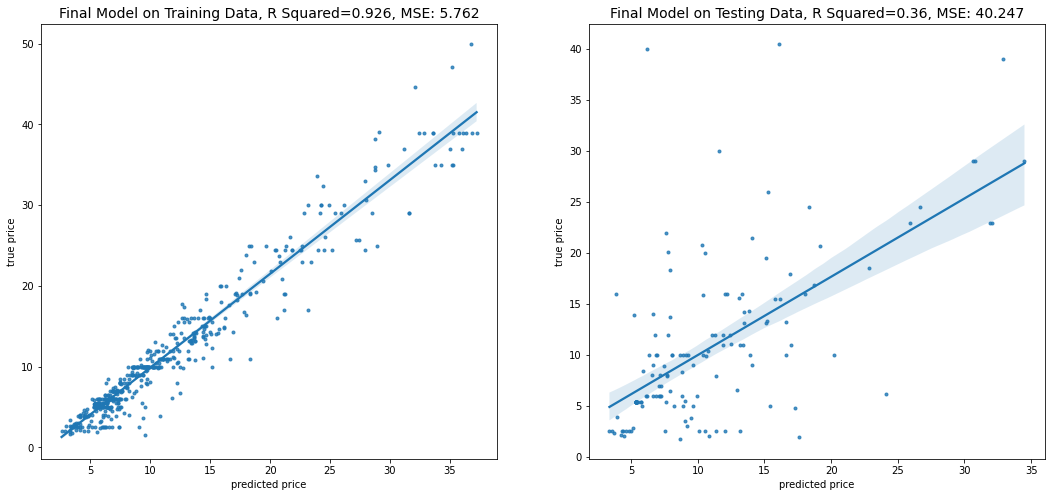

In [ ]:
# Conduct Random Forest Regression
model = RandomForestRegressor(n_estimators=best_params[0], criterion='squared_error', max_depth=best_params[1], max_features='auto')
model.fit(X_tup, y_tup)
plt.figure(figsize=(18,8))
plt.subplot(121)
preds=model.predict(X_tup)
plt.title('Final Model on Training Data, R Squared='+ str(np.round(model.score(X_tup, y_tup),3))+ ', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_tup),3)),size=14)
sns.regplot(x=preds[::1],y=y_tup[::1],marker='.');
plt.xlabel('predicted price')
plt.ylabel('true price')
plt.subplot(122)
preds=model.predict(X_testup)
plt.title('Final Model on Testing Data, R Squared='+ str(np.round(model.score(X_testup, y_testup),3))+', MSE: ' + str(np.round(sklearn.metrics.mean_squared_error(preds, y_testup),3)),size=14)
sns.regplot(x=(preds[::1]),y=(y_testup[::1]),marker='.')
plt.xlabel('predicted price')
plt.ylabel('true price');

In [ ]:
len(X_tup), len(X_testup)

(562, 141)